In [1]:
import numpy as np
import netCDF4 as nc
import auxiliary as au
import regression as reg
import datetime as dt
from matplotlib import pyplot as plt
from scipy import io
import os
import sys
from scipy.interpolate import griddata

########################################################################################################################
# 0. read/define configuration information
# setting: file and path names of inputs
FileStnInfo = '/Users/localuser/GMET/Example_tgq/inputs/stnlist_example.txt'  # station basic information (lists)
FileGridInfo = '/Users/localuser/GMET/Example_tgq/inputs/gridinfo_example.nc'  # study area information
PathStn = '/Users/localuser/GMET/Example_tgq/StnDaily_train'  # original station data (prcp ...)
# FileStnInfo = '/Users/localuser/GMET/pyGMET_NA/stnlist_whole.txt'  # station basic information (lists)
# FileGridInfo = '/Users/localuser/GMET/pyGMET_NA/gridinfo_whole.nc'  # study area information
# PathStn = '/Users/localuser/GMET/StnInput_daily'
# Plato
# FileStnInfo = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/CrossValidate/stnlist_whole_CV1.txt'  # station basic information (lists)
# FileGridInfo = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/gridinfo_whole.nc'  # study area information
# PathStn = '/home/gut428/GMET/StnInput_daily'

# setting: start and end date
# calculation start/end date:
date_cal_start = 20180801  # yyyymmdd: start date
date_cal_end = 20180831  # yyyymmdd: end date
# station data (in PathStn) start/end date:
date_stn_start = 20180801  # yyyymmdd: start date
date_stn_end = 20180831  # yyyymmdd: end date

# setting: paramters for lag correlation of tmean_stn_daily, and cross-correlation between prcp and trange_stn_daily
windows = 31  # parameters for auto-cc t-p-cc calculation: 1 could be better than 31
lag = 1

# setting: searching nearby stations
nearstn_min = 20  # nearby stations: minimum number
nearstn_max = 30  # nearby stations: maximum number
search_radius = 1000  # km. only search stations within this radius even nearstn_max cannot be reached
max_dist = 100  # max_distance in distance-based weight calculation

# note: if cai_mode = 0, all *_climo and *_anom files won't work.
# setting: parameters for transforming temp to approximate normal distribution
trans_mode = 'box-cox'  # box-cox or power-law or none
trans_exp_daily = 4

# setting: overwrite flags. -1:don't save files; 0: don't overwrite files; 1 is to overwrite existing files;
ow_daily = 1
ow_weight = 0
ow_stn = 0

# setting: output files
# FileStnData = '/home/gut428/PyGMET/station_CV1_data.npz'
# FileWeight = '/home/gut428/PyGMET/weight_CV1_nearstn.npz'
# FileRegError_daily = '/home/gut428/PyGMET/regress_daily_CV1_error.npz'  # regression error at station points
# FileRegression_daily = '/home/gut428/PyGMET/regress_daily_CV1_output.npz'
# FileStnData = '/Users/localuser/GMET/Example/station_data.npz'
# FileWeight = '/Users/localuser/GMET/Example/weight_nearstn.npz'
# FileRegError_daily = '/Users/localuser/GMET/Example/regress_daily_error.npz'  # regression error at station points
# FileRegression_daily = '/Users/localuser/GMET/Example/regress_daily_output.npz'
FileStnData = '/Users/localuser/GMET/pyGMET_res2/station_data.npz'
FileWeight = '/Users/localuser/GMET/pyGMET_res2/weight_nearstn.npz'
FileRegError_daily = '/Users/localuser/GMET/pyGMET_res2/regress_daily_error_boxcox.npz'  # regression error at station points
FileRegression_daily = '/Users/localuser/GMET/pyGMET_res2/regress_daily_output_boxcox.npz'

# setting: climatologically aided interpolation (CAI)
# CAI mode is not mature for now
cai_mode = 0  # 0: don't use CAI; 1: for each month; 2: calculate climatology using all months during the period
daily_flag = 1  # if cai_mode >0, then if daily_flag=1, do daily regression, else, do not do daily regression
ow_climo = 0
ow_anom = 0
trans_exp_anom = 3  # following fortran version. But I think if negative value occurs, just assign zero anomaly prcp
trans_exp_climo = 4
FileRegError_climo = '/Users/localuser/GMET/pyGMET_NA/regress_climo_error.npz'
FileRegression_climo = '/Users/localuser/GMET/pyGMET_NA/regress_climo_output.npz'
FileRegError_anom = '/Users/localuser/GMET/pyGMET_NA/regress_anom_error.npz'
FileRegression_anom = '/Users/localuser/GMET/pyGMET_NA/regress_anom_output.npz'

########################################################################################################################

# check file status
# this part should be activated in operational application
# if os.path.isfile(FileRegression_daily) and ow_daily != 1:
#     print('Condition-1:', FileRegression_daily, 'exists')
#     print('Condition-2: ow_daily != 1')
#     sys.exit('Output files have been generated. Exit the program')

########################################################################################################################

# 1. basic information

print('Read study area basic information')
# station location and attribute information
# stninfo: [ stations, 1/lat/lon/elev/slope_ns/slope_we ]
stnID, stninfo = au.readstnlist(FileStnInfo)
nstn = len(stnID)

# time information
if date_cal_start < date_stn_start:
    sys.exit('The calculation period is earlier than the station period')
if date_cal_end > date_stn_end:
    sys.exit('The calculation period is later than the station period')

date_cal_start2 = dt.datetime.strptime(str(date_cal_start), '%Y%m%d')
date_cal_end2 = dt.datetime.strptime(str(date_cal_end), '%Y%m%d')
ntimes = (date_cal_end2 - date_cal_start2).days + 1  # time steps to be processed

date_stn_start2 = dt.datetime.strptime(str(date_stn_start), '%Y%m%d')
loc_start = (date_cal_start2 - date_stn_start2).days  # start location in the netcdf file
loc_end = loc_start + ntimes

# seconds since 1970-1-1 0:0:0
daydiff = (date_cal_start2 - dt.datetime(1970, 1, 1)).days
seconds = (np.arange(ntimes) + daydiff) * 86400

# datelist: yyyymmdd
yyyymmdd = np.zeros(ntimes, dtype=int)
for d in range(ntimes):
    dated = date_cal_start2 + dt.timedelta(days=d)
    yyyymmdd[d] = int(dated.strftime("%Y%m%d"))
yyyymm = np.floor(yyyymmdd / 100).astype(int)
mm = np.floor(np.mod(yyyymmdd, 10000) / 100).astype(int)

########################################################################################################################

# 2. read study area basic information
print('Read study area basic information')
ncfid = nc.Dataset(FileGridInfo)
gridlat = ncfid.variables['latitude'][:].data
gridlon = ncfid.variables['longitude'][:].data
gridele = ncfid.variables['elev'][:].data
gridgns = ncfid.variables['gradient_n_s'][:].data
gridgwe = ncfid.variables['gradient_w_e'][:].data
mask = ncfid.variables['mask'][:].data  # 1: grids to be considered; the other values: invalid grids
ncfid.close()

nrows, ncols = np.shape(gridlat)
gridinfo = np.zeros([nrows, ncols, 6])
gridinfo[:, :, 0] = 1
gridinfo[:, :, 1] = gridlat
gridinfo[:, :, 2] = gridlon
gridinfo[:, :, 3] = gridele
gridinfo[:, :, 4] = gridgns
gridinfo[:, :, 5] = gridgwe
del gridlat, gridlon, gridele, gridgns, gridgwe

########################################################################################################################

# 3. read data (prcp, tmin, tmax) from station files
print('Read station precipitation and temperature data')
if os.path.isfile(FileStnData) and ow_stn != 1:
    print('FileStnData exists. loading ...')
    with np.load(FileStnData) as datatemp:
        prcp_stn_daily = datatemp['prcp_stn_daily']
        tmean_stn_daily = datatemp['tmean_stn_daily']
        trange_stn_daily = datatemp['trange_stn_daily']
        prcp_stn_climo = datatemp['prcp_stn_climo']
        tmean_stn_climo = datatemp['tmean_stn_climo']
        trange_stn_climo = datatemp['trange_stn_climo']
        prcp_stn_anom = datatemp['prcp_stn_anom']
        tmean_stn_anom = datatemp['tmean_stn_anom']
        trange_stn_anom = datatemp['trange_stn_anom']
else:
    prcp_stn_daily, tmean_stn_daily, trange_stn_daily, \
    prcp_stn_climo, tmean_stn_climo, trange_stn_climo, \
    prcp_stn_anom, tmean_stn_anom, trange_stn_anom \
        = au.read_station(PathStn, stnID, loc_start, loc_end, cai_mode, yyyymm)
    np.savez_compressed(FileStnData,
                        prcp_stn_daily=prcp_stn_daily, tmean_stn_daily=tmean_stn_daily, trange_stn_daily=trange_stn_daily,
                        prcp_stn_climo=prcp_stn_climo, tmean_stn_climo=tmean_stn_climo, trange_stn_climo=trange_stn_climo,
                        prcp_stn_anom=prcp_stn_anom, tmean_stn_anom=tmean_stn_anom, trange_stn_anom=trange_stn_anom)

if cai_mode == 0:
    del prcp_stn_climo, tmean_stn_climo, trange_stn_climo, prcp_stn_anom, tmean_stn_anom, trange_stn_anom
elif daily_flag != 1:
    del prcp_stn_daily, tmean_stn_daily, trange_stn_daily

########################################################################################################################

# 4. calculate auto_corr and t_p_corr
print('Calculate correlation (auto_cc and t_p_cc)')
if cai_mode == 0 or daily_flag == 1:
    mean_autocorr_daily, mean_tp_corr_daily = au.cc_calculate(windows, lag, prcp_stn_daily, tmean_stn_daily,
                                                              trange_stn_daily)
    print('Tmean lag-1 daily autocorrelation: ', mean_autocorr_daily)
    print('Trange-prcp daily correlation: ', mean_tp_corr_daily)

if cai_mode == 1:
    mean_autocorr_climo, mean_tp_corr_climo = au.cc_calculate(1, lag, prcp_stn_climo, tmean_stn_climo, trange_stn_climo)
    print('Tmean lag-1 climo autocorrelation: ', mean_autocorr_climo)
    print('Trange-prcp climo correlation: ', mean_tp_corr_climo)

    mean_autocorr_anom, mean_tp_corr_anom = au.cc_calculate(1, lag, prcp_stn_anom, tmean_stn_anom, trange_stn_anom)
    print('Tmean lag-1 anom autocorrelation: ', mean_autocorr_anom)
    print('Trange-prcp anom correlation: ', mean_tp_corr_anom)

########################################################################################################################

# 5. find neighboring stations and calculate distance-based weights
if os.path.isfile(FileWeight) and ow_weight != 1:
    print('FileWeight exists. loading ...')
    with np.load(FileWeight) as datatemp:
        near_grid_prcpLoc = datatemp['near_grid_prcpLoc']
        near_grid_prcpWeight = datatemp['near_grid_prcpWeight']
        near_grid_tempLoc = datatemp['near_grid_tempLoc']
        near_grid_tempWeight = datatemp['near_grid_tempWeight']
        near_stn_prcpLoc = datatemp['near_stn_prcpLoc']
        near_stn_prcpWeight = datatemp['near_stn_prcpWeight']
        near_stn_tempLoc = datatemp['near_stn_tempLoc']
        near_stn_tempWeight = datatemp['near_stn_tempWeight']
    del datatemp
else:
    near_grid_prcpLoc, near_grid_prcpDist, near_grid_prcpWeight, \
    near_grid_tempLoc, near_grid_tempDist, near_grid_tempWeight, \
    near_stn_prcpLoc, near_stn_prcpDist, near_stn_prcpWeight, \
    near_stn_tempLoc, near_stn_tempDist, near_stn_tempWeight \
        = au.station_weight(prcp_stn_daily, tmean_stn_daily, stninfo, gridinfo, mask,
                            search_radius, nearstn_min, nearstn_max, max_dist)

    # save data
    np.savez_compressed(FileWeight, near_grid_prcpLoc=near_grid_prcpLoc, near_grid_prcpDist=near_grid_prcpDist,
                        near_grid_prcpWeight=near_grid_prcpWeight, near_grid_tempLoc=near_grid_tempLoc,
                        near_grid_tempDist=near_grid_tempDist, near_grid_tempWeight=near_grid_tempWeight,
                        near_stn_prcpLoc=near_stn_prcpLoc, near_stn_prcpDist=near_stn_prcpDist,
                        near_stn_prcpWeight=near_stn_prcpWeight, near_stn_tempLoc=near_stn_tempLoc,
                        near_stn_tempDist=near_stn_tempDist, near_stn_tempWeight=near_stn_tempWeight)

########################################################################################################################

# 6. start spatial regression

########################################################################################################################

# 6.1 estimate regression error at station points
# 6.1.1 daily mode
if cai_mode == 0 or daily_flag == 1:
    if os.path.isfile(FileRegError_daily) and ow_daily != 1:
        print('FileRegError_daily exists. loading ...')
        with np.load(FileRegError_daily) as datatemp:
            pcp_err_stn_daily = datatemp['pcp_err_stn']
            tmean_err_stn_daily = datatemp['tmean_err_stn']
            trange_err_stn_daily = datatemp['trange_err_stn']
        del datatemp
    else:
        print('Estimate daily regression error at station points')
        pcp_err_stn_daily, tmean_err_stn_daily, trange_err_stn_daily = \
            reg.station_error(prcp_stn_daily, tmean_stn_daily, trange_stn_daily, stninfo, near_stn_prcpLoc,
                              near_stn_prcpWeight, near_stn_tempLoc, near_stn_tempWeight, trans_exp_daily,
                              trans_mode, nearstn_min)
        np.savez_compressed(FileRegError_daily, pcp_err_stn=pcp_err_stn_daily, tmean_err_stn=tmean_err_stn_daily,
                            trange_err_stn=trange_err_stn_daily, stninfo=stninfo)

# 6.1.2 climotological mode (climo and anomaly)
if cai_mode == 1:
    # climo mode
    if os.path.isfile(FileRegression_climo) and ow_climo != 1:
        print('FileRegError_climo exists. loading ...')
        with np.load(FileRegError_climo) as datatemp:
            pcp_err_stn_climo = datatemp['pcp_err_stn']
            tmean_err_stn_climo = datatemp['tmean_err_stn']
            trange_err_stn_climo = datatemp['trange_err_stn']
        del datatemp
    else:
        print('Estimate climo regression error at station points')
        pcp_err_stn_climo, tmean_err_stn_climo, trange_err_stn_climo = \
            reg.station_error(prcp_stn_climo, tmean_stn_climo, trange_stn_climo, stninfo, near_stn_prcpLoc,
                              near_stn_prcpWeight, near_stn_tempLoc, near_stn_tempWeight, trans_exp_climo,
                              trans_mode, nearstn_min)
        np.savez_compressed(FileRegError_climo, pcp_err_stn=pcp_err_stn_climo, tmean_err_stn=tmean_err_stn_climo,
                            trange_err_stn=trange_err_stn_climo, stninfo=stninfo)

    # anomaly mode
    if os.path.isfile(FileRegression_anom) and ow_anom != 1:
        print('FileRegError_anom exists. loading ...')
        with np.load(FileRegError_anom) as datatemp:
            pcp_err_stn_anom = datatemp['pcp_err_stn']
            tmean_err_stn_anom = datatemp['tmean_err_stn']
            trange_err_stn_anom = datatemp['trange_err_stn']
        del datatemp
    else:
        print('Estimate anom regression error at station points')
        pcp_err_stn_anom, tmean_err_stn_anom, trange_err_stn_anom = \
            reg.station_error(prcp_stn_anom, tmean_stn_anom, trange_stn_anom, stninfo, near_stn_prcpLoc,
                              near_stn_prcpWeight,
                              near_stn_tempLoc, near_stn_tempWeight, trans_exp_anom, trans_mode, nearstn_min)
        np.savez_compressed(FileRegError_anom, pcp_err_stn=pcp_err_stn_anom,tmean_err_stn=tmean_err_stn_anom,
                            trange_err_stn=trange_err_stn_anom, stninfo=stninfo)

########################################################################################################################

# 6.2 regression for each grid cell
# 6.2.1 daily mode
if cai_mode == 0 or daily_flag == 1:
    if (not os.path.isfile(FileRegression_daily)) or ow_daily == 1:
        print('Locally weighted regression of daily precipitation and temperature')
        pop_daily, pcp_daily, tmean_daily, trange_daily, pcp_err_daily, tmean_err_daily, trange_err_daily, y_max_daily = \
            reg.regression(prcp_stn_daily, tmean_stn_daily, trange_stn_daily, pcp_err_stn_daily, tmean_err_stn_daily,
                           trange_err_stn_daily, stninfo, gridinfo, mask, near_grid_prcpLoc,
                           near_grid_prcpWeight, near_grid_tempLoc, near_grid_tempWeight,
                           nearstn_min, nearstn_max, trans_exp_daily, trans_mode)
        np.savez_compressed(FileRegression_daily, pop=pop_daily, pcp=pcp_daily, tmean=tmean_daily, trange=trange_daily,
                            pcp_err=pcp_err_daily, tmean_err=tmean_err_daily, trange_err=trange_err_daily,
                            y_max=y_max_daily)
        # au.save_output_nc(FileRegression_daily, gridinfo, seconds, mean_autocorr_daily, mean_tp_corr_daily,
        #                   pop_daily, pcp_daily, tmean_daily, trange_daily,
        #                   pcp_err_daily, tmean_err_daily, trange_err_daily, y_max_daily)

# 6.2.2 climotological mode (climo and anomaly)
if cai_mode == 1:
    if (not os.path.isfile(FileRegression_climo)) or ow_climo == 1:
        print('Locally weighted regression of climo precipitation and temperature')
        pop_climo, pcp_climo, tmean_climo, trange_climo, pcp_err_climo, tmean_err_climo, trange_err_climo, y_max_climo = \
            reg.regression(prcp_stn_climo, tmean_stn_climo, trange_stn_climo, pcp_err_stn_climo, tmean_err_stn_climo,
                           trange_err_stn_climo, stninfo, gridinfo, mask,near_grid_prcpLoc,
                           near_grid_prcpWeight, near_grid_tempLoc, near_grid_tempWeight,
                           nearstn_min, nearstn_max, trans_exp_climo, trans_mode)
        np.savez_compressed(FileRegression_climo, pop=pop_climo, pcp=pcp_climo, tmean=tmean_climo, trange=trange_climo,
                            pcp_err=pcp_err_climo, tmean_err=tmean_err_climo, trange_err=trange_err_climo,
                            y_max=y_max_climo)
        # au.save_output_nc(FileRegression_climo, gridinfo, np.mean(seconds), mean_autocorr_climo, mean_tp_corr_climo,
        #                   pop_climo, pcp_climo, tmean_climo, trange_climo,
        #                   pcp_err_climo, tmean_err_climo, trange_err_climo, y_max_climo)

    if (not os.path.isfile(FileRegression_anom)) or ow_anom == 1:
        print('Locally weighted regression of anom precipitation and temperature')
        pop_anom, pcp_anom, tmean_anom, trange_anom, pcp_err_anom, tmean_err_anom, trange_err_anom, y_max_anom = \
            reg.regression(prcp_stn_anom, tmean_stn_anom, trange_stn_anom, pcp_err_stn_anom, tmean_err_stn_anom,
                           trange_err_stn_anom, stninfo, gridinfo, mask,near_grid_prcpLoc,
                           near_grid_prcpWeight, near_grid_tempLoc, near_grid_tempWeight,
                           nearstn_min, nearstn_max, trans_exp_anom, trans_mode)
        np.savez_compressed(FileRegression_anom, pop=pop_anom, pcp=pcp_anom, tmean=tmean_anom, trange=trange_anom,
                            pcp_err=pcp_err_anom, tmean_err=tmean_err_anom, trange_err=trange_err_anom,
                            y_max=y_max_anom)
        # au.save_output_nc(FileRegression_anom, gridinfo, seconds, mean_autocorr_anom, mean_tp_corr_anom,
        #                   pop_anom, pcp_anom, tmean_anom, trange_anom,
        #                   pcp_err_anom, tmean_err_anom, trange_err_anom, y_max_anom)

########################################################################################################################

# Note: the following codes are for data analysis and is necessary for operational application

########################################################################################################################

# 7. load regression files for analysis
if cai_mode == 0 or daily_flag == 1:
    with np.load(FileRegression_daily) as datatemp:
        pop_daily = datatemp['pop']
        pcp_daily = datatemp['pcp']
        tmean_daily = datatemp['tmean']
        trange_daily = datatemp['trange']
        pcp_err_daily = datatemp['pcp_err']
        tmean_err_daily = datatemp['tmean_err']
        trange_err_daily = datatemp['trange_err']
        y_max_daily = datatemp['y_max']
    del datatemp

if cai_mode == 1:
    with np.load(FileRegression_climo) as datatemp:
        pop_climo = datatemp['pop']
        pcp_climo = datatemp['pcp']
        tmean_climo = datatemp['tmean']
        trange_climo = datatemp['trange']
        pcp_err_climo = datatemp['pcp_err']
        tmean_err_climo = datatemp['tmean_err']
        trange_err_climo = datatemp['trange_err']
        y_max_climo = datatemp['y_max']
    del datatemp

    with np.load(FileRegression_anom) as datatemp:
        pop_anom = datatemp['pop']
        pcp_anom = datatemp['pcp']
        tmean_anom = datatemp['tmean']
        trange_anom = datatemp['trange']
        pcp_err_anom = datatemp['pcp_err']
        tmean_err_anom = datatemp['tmean_err']
        trange_err_anom = datatemp['trange_err']
        y_max_anom = datatemp['y_max']
    del datatemp


# 8. recover from anomaly estimation to daily estimation
if cai_mode == 0 or daily_flag == 1:
    prcp_stn_REGdaily = au.retransform(pcp_err_stn_daily + au.transform(prcp_stn_daily, trans_exp_daily, trans_mode),
                                       trans_exp_daily, trans_mode)
    tmean_stn_REGdaily = tmean_err_stn_daily + tmean_stn_daily
    trange_stn_REGdaily = trange_err_stn_daily + trange_stn_daily
    pcp_daily = au.retransform(pcp_daily, trans_exp_daily, trans_mode)

if cai_mode == 1:
    prcp_stn_CAIdaily, tmean_stn_CAIdaily, trange_stn_CAIdaily, \
    prcp_CAIdaily, tmean_CAIdaily, trange_CAIdaily = \
        au.climoanom_to_daily(prcp_stn_climo, tmean_stn_climo, trange_stn_climo,  # station observation: climo
                           prcp_stn_anom, tmean_stn_anom, trange_stn_anom,
                           pcp_err_stn_climo, tmean_err_stn_climo, trange_err_stn_climo,
                           pcp_err_stn_anom, tmean_err_stn_anom, trange_err_stn_anom,
                           pcp_climo, tmean_climo, trange_climo, pcp_anom, tmean_anom, trange_anom,
                           yyyymm, trans_exp_climo, trans_exp_anom, trans_mode)


Read study area basic information
Read study area basic information
Read station precipitation and temperature data
FileStnData exists. loading ...
Calculate correlation (auto_cc and t_p_cc)
Tmean lag-1 daily autocorrelation:  0.5391207428761793
Trange-prcp daily correlation:  -0.1960710499655917
FileWeight exists. loading ...
Estimate daily regression error at station points
Current time: 0 Total times: 31


/Users/localuser/Github/PyGMET/auxiliary.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(FileStnInfo, delimiter=',', dtype=None, skip_header=2)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/localuser/Github/PyGMET/auxiliary.py:183: RuntimeWarning: invalid value encountered in greater
  auto_corr[abs(auto_corr) > 1] = np.nan
/Users/localuser/Github/PyGMET/auxiliary.py:184: RuntimeWarning: invalid value encountered in greater
  t_p_corr[abs(t_p_corr) > 1] = np.nan


Current time: 1 Total times: 31
Current time: 2 Total times: 31
Current time: 3 Total times: 31
Current time: 4 Total times: 31
Current time: 5 Total times: 31
Current time: 6 Total times: 31
Current time: 7 Total times: 31
Current time: 8 Total times: 31
Current time: 9 Total times: 31
Current time: 10 Total times: 31
Current time: 11 Total times: 31
Current time: 12 Total times: 31
Current time: 13 Total times: 31
Current time: 14 Total times: 31
Current time: 15 Total times: 31
Current time: 16 Total times: 31
Current time: 17 Total times: 31
Current time: 18 Total times: 31
Current time: 19 Total times: 31
Current time: 20 Total times: 31
Current time: 21 Total times: 31
Current time: 22 Total times: 31
Current time: 23 Total times: 31
Current time: 24 Total times: 31
Current time: 25 Total times: 31
Current time: 26 Total times: 31
Current time: 27 Total times: 31
Current time: 28 Total times: 31
Current time: 29 Total times: 31
Current time: 30 Total times: 31
Locally weighted re

/Users/localuser/Github/PyGMET/regression.py:274: RuntimeWarning: overflow encountered in exp
  pop[rr, cc, t] = 1 / (1 + np.exp(zb))


Regression time step:  2 ---Total time steps:  31
Regression time step:  3 ---Total time steps:  31
Regression time step:  4 ---Total time steps:  31
Regression time step:  5 ---Total time steps:  31
Regression time step:  6 ---Total time steps:  31
Regression time step:  7 ---Total time steps:  31
Regression time step:  8 ---Total time steps:  31
Regression time step:  9 ---Total time steps:  31
Regression time step:  10 ---Total time steps:  31
Regression time step:  11 ---Total time steps:  31
Regression time step:  12 ---Total time steps:  31
Regression time step:  13 ---Total time steps:  31
Regression time step:  14 ---Total time steps:  31
Regression time step:  15 ---Total time steps:  31
Regression time step:  16 ---Total time steps:  31
Regression time step:  17 ---Total time steps:  31
Regression time step:  18 ---Total time steps:  31
Regression time step:  19 ---Total time steps:  31
Regression time step:  20 ---Total time steps:  31
Regression time step:  21 ---Total time

/Users/localuser/Github/PyGMET/auxiliary.py:91: RuntimeWarning: invalid value encountered in less
  data[data < -3] = -3


/Users/localuser/Github/PyGMET/auxiliary.py:91: RuntimeWarning: invalid value encountered in less
  data[data < -3] = -3


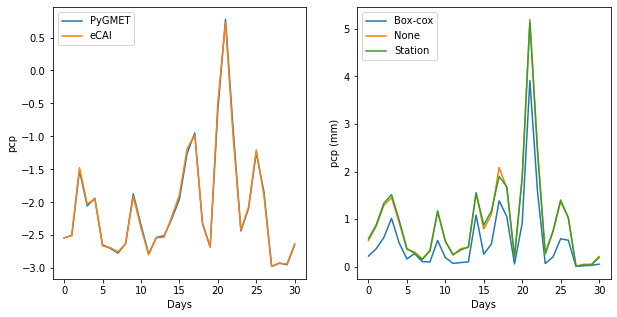

0.5377803392841671 0.9555936891278087 0.9595550342437535


In [20]:
import numpy as np
import netCDF4 as nc
import auxiliary as au
import regression as reg
import datetime as dt
from matplotlib import pyplot as plt
from scipy import io
import os
import sys
from scipy.interpolate import griddata

# # read original station data
# path='/Users/localuser/GMET/Example_tgq/StnDaily_train'
# files = os.listdir(path)
# pcpstn = np.nan * np.zeros([len(files),31])
# for i in range(len(files)):
#     filef = path + '/' + files[i]
#     fid = nc.Dataset(filef)
#     if 'prcp' in fid.variables.keys():
#         pcpstn[i,:] = fid['prcp'][:].data
#     fid.close()
# pcpstnm = np.nanmean(pcpstn,axis=0)

file0='/Users/localuser/GMET/pyGMET_res2/station_data.npz'
dd = np.load(file0)
pcpstn = prcp_stn_daily
pcpstnm = np.nanmean(pcpstn,axis=0)

file1='/Users/localuser/GMET/pyGMET_res2/regress_daily_error_boxcox.npz'
dd = np.load(file1)
pcperr = dd['pcp_err_stn']
pcp1 = au.retransform(au.transform(pcpstn,4,'box-cox')+pcperr,4,'box-cox')
pcp1m = np.nanmean(pcp1,axis=0)

file2='/Users/localuser/GMET/pyGMET_res2/regress_daily_error_none.npz'
dd = np.load(file2)
pcperr = dd['pcp_err_stn']
pcp2 = pcpstn+pcperr
pcp2m = np.nanmean(pcp2,axis=0)


plt.figure(figsize=(10, 5))


plt.subplot(121)
plt.plot(pcp1m0)
plt.plot(pcp2m0)
plt.legend(['PyGMET', 'eCAI'])
plt.xlabel('Days')
plt.ylabel('pcp')
plt.subplot(122)
plt.plot(pcp1m)
plt.plot(pcp2m)
plt.plot(pcpstnm)
plt.legend(['Box-cox', 'None','Station'])
plt.xlabel('Days')
plt.ylabel('pcp (mm)')
plt.show()

print(np.mean(pcp1m),np.mean(pcp2m),np.mean(pcpstnm))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice


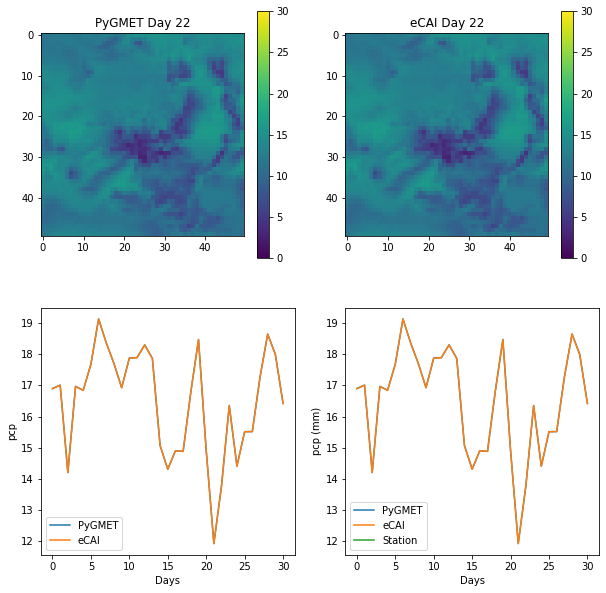

In [29]:
import numpy as np
import netCDF4 as nc
import auxiliary as au
import regression as reg
import datetime as dt
from matplotlib import pyplot as plt
from scipy import io
import os
import sys
from scipy.interpolate import griddata

file = '/Users/localuser/GMET/pyGMET_res2/regress_daily_output.npz'
dd = np.load(file)
pcp1 = dd['trange']

file = '/Users/localuser/GMET/Example_tgq/outputs_eCAImodify/regress_daily.nc'
dd = nc.Dataset(file)
pcp2 = dd['trange'][:].data
dd.close()
pcp2 = np.transpose(pcp2, [1, 2, 0])
# pcp2[pcp2 == 0] = -3

pcp1m0 = np.zeros(31)
pcp2m0 = np.zeros(31)
for i in range(31):
    pcp1m0[i] = np.nanmean(pcp1[:, :, i])
    pcp2m0[i] = np.nanmean(pcp2[:, :, i])

# pcp1 = au.retransform(pcp1, 4, 'box-cox')
# pcp2 = au.retransform(pcp2, 4, 'box-cox')

pcp1m = np.zeros(31)
pcp2m = np.zeros(31)
for i in range(31):
    pcp1m[i] = np.nanmean(pcp1[:, :, i])
    pcp2m[i] = np.nanmean(pcp2[:, :, i])


# read original station data
path='/Users/localuser/GMET/Example_tgq/StnDaily_train'
files = os.listdir(path)
pcpstn = np.nan * np.zeros([len(files),31])
for i in range(len(files)):
    filef = path + '/' + files[i]
    fid = nc.Dataset(filef)
    if 'trange' in fid.variables.keys():
        pcpstn[i,:] = fid['trange'][:].data
    fid.close()
pcpstnm = np.nanmean(pcpstn,axis=0)

plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.imshow(pcp1[:, :, 21])
plt.colorbar()
plt.title('PyGMET Day 22')
plt.clim([0, 30])
plt.subplot(222)
plt.imshow(pcp2[:, :, 21])
plt.title('eCAI Day 22')
plt.clim([0, 30])
plt.colorbar()
plt.subplot(223)
plt.plot(pcp1m0)
plt.plot(pcp2m0)
plt.legend(['PyGMET', 'eCAI'])
plt.xlabel('Days')
plt.ylabel('pcp')
plt.subplot(224)
plt.plot(pcp1m)
plt.plot(pcp2m)
plt.plot(pcpstnm)
plt.legend(['PyGMET', 'eCAI','Station'])
plt.xlabel('Days')
plt.ylabel('pcp (mm)')
plt.show()

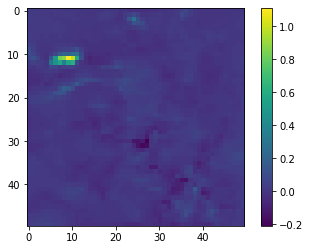

In [39]:
diff = pcp1-pcp2
ratio = diff/pcp2
plt.imshow(diff[:,:,3])
plt.colorbar()

In [32]:
np.shape(pcp1)

(50, 50, 31)